# Navigation

---


### 1. Start the Environment

Import some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from unityagents import UnityEnvironment
from src.dqn_agent import Agent
from utils.util import save_checkpoint

%matplotlib inline

%load_ext autoreload
%autoreload 2

Load Banana Environment from Unity ML-Agents
**Note:** On MacOS you might get an `OSError: handle is closed`. In this case you should restart the Kernel of the notebook (go to Kernel tab and click on Restart).

In [2]:
env = UnityEnvironment(file_name="env/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Train Agent with (Vanilla) DQN

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction.

In [4]:
agent = Agent(state_size=37, action_size=4, seed=0)

Episode 100	Average Score: 0.88
Episode 200	Average Score: 4.46
Episode 300	Average Score: 7.38
Episode 400	Average Score: 11.32
Episode 484	Average Score: 13.00
Environment solved in 384 episodes!	Average Score: 13.00
=> Saving checkpoint...


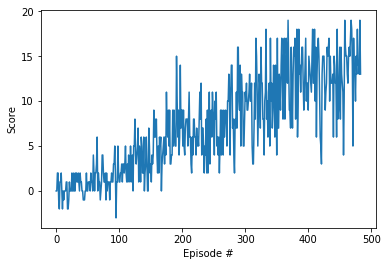

In [5]:
def dqn(n_episodes=1800, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get the current state
        score = 0                                         # initialize the score
        for t in range(max_t):                            # learn for max_t steps
            action = agent.act(state, eps)                 # choose an action by following a behavioral policy
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # observe the next state and reward
            reward = env_info.rewards[0]
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # learn from experience
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        avg_reward = np.mean(scores_window)
        # Maybe log some statistics
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_reward), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_reward))
        # Note: Taks is solved if agent receives at least an average score of 13 over the last 100 episodes
        if avg_reward >= 13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_reward))
            save_checkpoint({
                'episode': i_episode,
                'state_dict': agent.qnetwork_local.state_dict(),
                'avg_reward': avg_reward
            }, 'checkpoints/checkpoint.pth')
            break
    return scores

# train the agent
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
env.close()

### 3. Watch a Smart Agent 

In [5]:
# load load weights of qnetwork of smart agent
load_path = 'checkpoints/checkpoint.pth'
cuda = torch.cuda.is_available()

if cuda:
    checkpoint = torch.load(load_path)
else:
    # Load GPU model on CPU
    checkpoint = torch.load(load_path,
                        map_location=lambda storage, loc: storage)
agent.qnetwork_local.load_state_dict(checkpoint['state_dict'])
num_episodes_test = 1
max_t = 300

for i in range(num_episodes_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for t in range(max_t):  # We assume the agent is capable of collecting all yellow bananas within max_t steps
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        rewards = env_info.rewards[0]
        done = env_info.local_done[0]
        if done:
            break
env.close()